In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Constants
epsilon_0 = 8.85e-12  # Permittivity of free space (Farad/meter)

In [64]:
# Material Parameters
dielectric = {
    "Al2O3": 7.0,  # Dielectric constant(k) of Al2O3)
    "HfO2": 25.0,  # Dielectric constant(k) of HfO2)
    "ZrO2": 20.0,  # Dielectric constant(k) of ZrO2)
    "TiO2": 80.0   # Dielectric constant(k) of ZrO2)
}
conductivity = {
    "Al2O3": 1e-13,  # conductivity() of Al2O3)
    "HfO2": 1e-6,    # conductivity() of HfO2)
    "ZrO2": 1e-12,   # conductivity() of ZrO2)
    "TiO2": 1e-11    # conductivity() of ZrO2)
}
breakdown = {
    "Al2O3": 30e+8,  # Breakdown voltage of Al2O3)
    "HfO2": 9e+8,    # Breakdown voltage of HfO2)
    "ZrO2": 15e+8,   # Breakdown voltage of ZrO2)
    "TiO2": 12e+6    # Dielectric constant(k) of TiO2)
}
sigma_interface = 1e-9  # Interfacial charge accumulation parameter (Siemens/meter), for old MW calc

# Simulation parameters
# layering
t = 2e-10
thickness = {
    "Al2O3": t,  # Thickness(m) of Al2O3 layer)
    "HfO2": t,   # Thickness(m) of HfO2 layer)
    "ZrO2": t,   # Thickness(m) of ZrO2 layer)
    "TiO2": t    # Thickness(m) of TiO2 layer)

}


In [65]:
# Dielectric Functions

def maxwell_wagner_dielectric_calc_v4(stack, thickness, dielectric, conductivity, w = 0, single = True):

    D = 0
    SR = 0
    SI = 0
    S = 0

    k_effs = []
    for i, mat in enumerate(stack):
        D += thickness[mat]
        SR += thickness[mat]*conductivity[mat] / (conductivity[mat]**2 + (w*dielectric[mat]*epsilon_0)**2)
        SI += w*thickness[mat]*dielectric[mat]*epsilon_0 / (conductivity[mat]**2 + (w*dielectric[mat]*epsilon_0)**2)
        S += thickness[mat]*dielectric[mat] / (conductivity[mat]**2 + (w*dielectric[mat]*epsilon_0)**2)
        #S += thickness[mat] / (conductivity[mat]**2 + (w*dielectric[mat]*epsilon_0)**2)


        k_eff = D*S/(SR**2 + SI**2)
        k_effs.append(k_eff)
    
    if single:
        return k_eff
    else:
        return k_effs

def maxwell_wagner_dielectric_calc_v2(stack, thickness, dielectric, conductivity, neighbor = False, single = True):
    '''Calculates effective dielectric constant using additional capacitance contribution from Maxwell Wagner model'''
    k_effs = []
    for i, mat in enumerate(stack):
        if i == 0:
            sigma_1 = conductivity[mat]
            d_1 = thickness[mat]
            epsilon_1 = dielectric[mat]
            tau_1 = epsilon_1*epsilon_0 / sigma_1

            k_eff = epsilon_1
            k_effs.append(k_eff)

            print(f"{mat}: sigma = {sigma_1}, tau = {tau_1}, k_eff = {k_eff}")
            continue

        sigma_2 = conductivity[mat]
        d_2 = thickness[mat]
        epsilon_2 = dielectric[mat]

        tau_2 = epsilon_2*epsilon_0 / sigma_2

        tau = epsilon_0*(epsilon_1*d_2 + epsilon_2*d_1) / (sigma_1*d_2 + sigma_2*d_1)
        sigma = sigma_1*sigma_2*(d_1+d_2) / (sigma_1*d_2 + sigma_2*d_1)

        k_eff = sigma*(tau_1+tau_2-tau) / epsilon_0
        k_effs.append(k_eff)

        # Prep parameters for next iteration
        if neighbor: # Uses the properties corresponding to the materials directly at the interface as opposed to just an effective circuit
            sigma_1 = sigma_2
            d_1 = d_1+d_2
            epsilon_1 = epsilon_2
        else: # Uses the properties corresponding to the effective circuit at each interface
            sigma_1 = sigma
            d_1 = d_1+d_2
            epsilon_1 = k_eff
        tau_1 = epsilon_1*epsilon_0 / sigma_1
        
        print(f"{mat}: sigma = {sigma}, tau = {tau}, k_eff = {k_eff}")
    
    if single:
        return k_eff
    else:
        return k_effs

def classical_dielectric_calc(stack, thickness, dielectric, single = True):
    k_effs = []
    k_eff = 0
    d_tot = 0
    S1 = 0
    for mat in stack:
        d_tot += thickness[mat]
        S1 += thickness[mat]/dielectric[mat]
        k_eff = d_tot / S1
        k_effs.append(k_eff)

    if single:
        return k_eff
    else:
        return k_effs


In [66]:
# Generate Stack

def generate_stack(stack_pattern, num_iterations, thickness, stacking = False, sizeing = False):
    '''Generates a dielectric stack based on a pattern and given number of layers'''
    # Interprets stack as stack of pattern, layers as individual materials
    if stacking: # Num_layers = 3*num_iterations + 1 for symmetric growth
        stack = stack_pattern*num_iterations + [stack_pattern[0]]
    else:
        stack = (stack_pattern*int(np.ceil(num_iterations/len(stack_pattern))))[:num_iterations]
    # Allows for boundary differences
    if sizeing: # Num_layers = num_iterations
        size = 0
        size = sum(thickness[mat] for mat in stack)
        return stack, size
    return stack

def generate_results(stack_pattern, num_layers, thickness, dielectric, conductivity, breakdown, w = 0, neighbor = False, closed_stacking = True, version = 'v4', layer_resolution = 3, min_layers = 1):
    '''Produces data for number of stacks vs dielectric and breakdown voltage'''
    stack = generate_stack(stack_pattern, num_layers, thickness, closed_stacking)

    if version == 'classical':
        k_effs = classical_dielectric_calc(stack, thickness, dielectric, single = False)
    elif version == 'v1':
        k_effs = maxwell_wagner_dielectric_calc_v1(stack, thickness, dielectric, single = False)
    elif version == 'v2':
        k_effs = maxwell_wagner_dielectric_calc_v2(stack, thickness, dielectric, conductivity, neighbor = neighbor, single = False)
    elif version == 'v3':
        k_effs = maxwell_wagner_dielectric_calc_v3(stack, thickness, dielectric, conductivity, single = False)
    elif version == 'v4':
        k_effs = maxwell_wagner_dielectric_calc_v4(stack, thickness, dielectric, conductivity, w = w, single = False)
    elif version == 'v5':
        k_effs = maxwell_wagner_dielectric_calc_v5(stack, thickness, dielectric, conductivity, single = False)
    elif version == 'v6':
        k_effs = maxwell_wagner_dielectric_calc_v6(stack, thickness, dielectric, conductivity, single = False)
        
    breakdown_Vs = linear_breakdown_calc(stack, breakdown, thickness, breakdown_E = False, single = False)

    k_effs, breakdown_Vs = k_effs[::layer_resolution], breakdown_Vs[::layer_resolution]
    layers = [i*layer_resolution for i in range(min_layers, len(k_effs)+1)]

    return layers, k_effs, breakdown_Vs

In [67]:
# Define stack pattern
# need to update if similar material names appear
materials = ["Al2O3", "ZrO2", "HfO2", "TiO2"]
from itertools import permutations
material_permutations = []
for i, material in enumerate(materials):
    material_permutations += list(permutations(materials, i+1))
stack_patterns = {"".join(m[0] for m in mat): list(mat) for mat in material_permutations}
print(stack_patterns)

{'A': ['Al2O3'], 'Z': ['ZrO2'], 'H': ['HfO2'], 'T': ['TiO2'], 'AZ': ['Al2O3', 'ZrO2'], 'AH': ['Al2O3', 'HfO2'], 'AT': ['Al2O3', 'TiO2'], 'ZA': ['ZrO2', 'Al2O3'], 'ZH': ['ZrO2', 'HfO2'], 'ZT': ['ZrO2', 'TiO2'], 'HA': ['HfO2', 'Al2O3'], 'HZ': ['HfO2', 'ZrO2'], 'HT': ['HfO2', 'TiO2'], 'TA': ['TiO2', 'Al2O3'], 'TZ': ['TiO2', 'ZrO2'], 'TH': ['TiO2', 'HfO2'], 'AZH': ['Al2O3', 'ZrO2', 'HfO2'], 'AZT': ['Al2O3', 'ZrO2', 'TiO2'], 'AHZ': ['Al2O3', 'HfO2', 'ZrO2'], 'AHT': ['Al2O3', 'HfO2', 'TiO2'], 'ATZ': ['Al2O3', 'TiO2', 'ZrO2'], 'ATH': ['Al2O3', 'TiO2', 'HfO2'], 'ZAH': ['ZrO2', 'Al2O3', 'HfO2'], 'ZAT': ['ZrO2', 'Al2O3', 'TiO2'], 'ZHA': ['ZrO2', 'HfO2', 'Al2O3'], 'ZHT': ['ZrO2', 'HfO2', 'TiO2'], 'ZTA': ['ZrO2', 'TiO2', 'Al2O3'], 'ZTH': ['ZrO2', 'TiO2', 'HfO2'], 'HAZ': ['HfO2', 'Al2O3', 'ZrO2'], 'HAT': ['HfO2', 'Al2O3', 'TiO2'], 'HZA': ['HfO2', 'ZrO2', 'Al2O3'], 'HZT': ['HfO2', 'ZrO2', 'TiO2'], 'HTA': ['HfO2', 'TiO2', 'Al2O3'], 'HTZ': ['HfO2', 'TiO2', 'ZrO2'], 'TAZ': ['TiO2', 'Al2O3', 'ZrO2'], 'T

In [71]:
# Working

stack_pattern = stack_patterns['ATH']
num_iterations = 400    #if stacking, num_layers = 3*num_iterations, else num_layers = num_iterations
#distance seems to dominate at about 1 mm for neighbor model

layer_resolution = int(len(stack_pattern)*np.ceil(num_iterations/200))

stack, size = generate_stack(stack_pattern, num_iterations, thickness, stacking = True, sizeing = True)
print("The stack spans", f"{size*1e+9:0.1f}", " nm, and has", len(stack), "layers")
print("Stack:", stack)

layers, k_effs, breakdown_Vs = generate_results(stack_pattern, num_iterations, thickness, 
                                                dielectric, conductivity, breakdown, w = 0, neighbor = False, 
                                                closed_stacking = True, version = 'v4', layer_resolution = layer_resolution, min_layers = 1)

print("The total dielectric constant is", f"{k_effs[-1]:.2f}", "and the breakdown voltage is", f"{breakdown_Vs[-1]:.2f}", "V")


The stack spans 240.2  nm, and has 1201 layers
Stack: ['Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'HfO2', 'Al2O3', 'TiO2', 'Hf

Number of Layers	Effective Dielectric Constant (MW Model)

 Total dielectric constant, K =  20.58


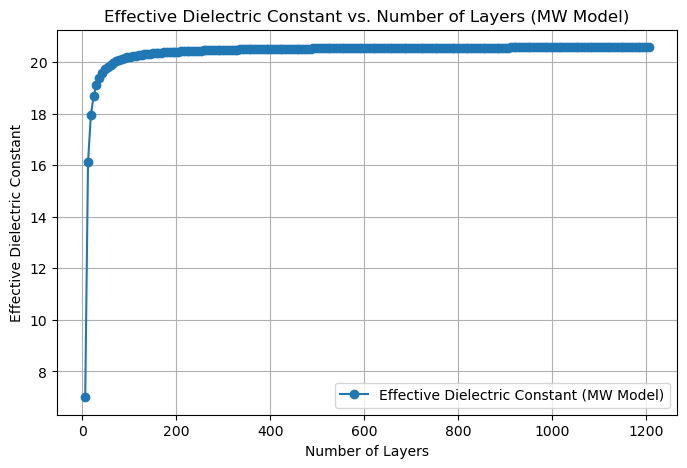

In [ ]:
# Dielectric Results

print("Number of Layers\tEffective Dielectric Constant (MW Model)")

print("\n Total dielectric constant, K = ", f"{k_effs[-1]:.2f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(layers, k_effs, marker="o", label="Effective Dielectric Constant (MW Model)")
plt.title("Effective Dielectric Constant vs. Number of Layers (MW Model)")
plt.xlabel("Number of Layers")
plt.ylabel("Effective Dielectric Constant")
plt.grid(True)
plt.legend()
plt.show()

Number of Layers	Breakdown Voltage

 Total breakdown voltage, V =  482.52


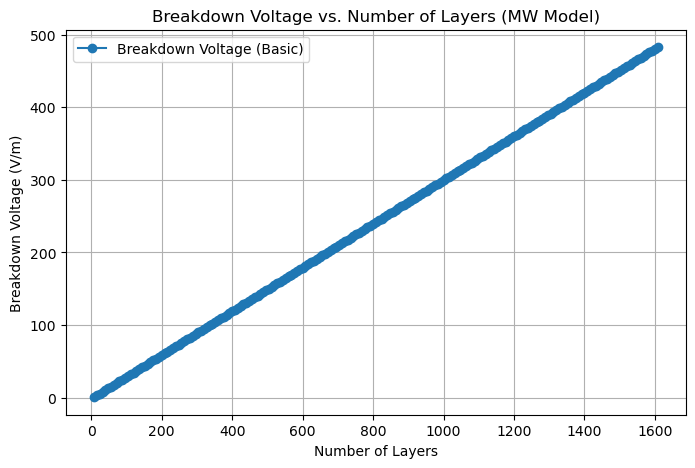

In [11]:
# Breakdown Voltage Results
print("Number of Layers\tBreakdown Voltage")

print("\n Total breakdown voltage, V = ", f"{breakdown_Vs[-1]:.2f}")

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(layers, breakdown_Vs, marker="o", label="Breakdown Voltage (Basic)")
plt.title("Breakdown Voltage vs. Number of Layers (MW Model)")
plt.xlabel("Number of Layers")
plt.ylabel("Breakdown Voltage (V/m)")
plt.grid(True)
plt.legend()
plt.show()

In [ ]:
"""Improvements:
 - Re-derive M-W model
     - Consider charge carriers, energy jumps, band bending, bond bending under electric field
 - 
 - Derive breakdown behaivor
 - figure out boundary between CNT? (--just encapsulated in dielectric)"""

In [ ]:
# Old Funcs

def maxwell_wagner_dielectric_calc_v6(stack, thickness, dielectric, conductivity, single = True):
    '''Calculates effective dielectric constant using additional capacitance contribution from Maxwell Wagner model'''
    k_effs = []

    k_eff = 0
    d_tot = 0
    S1 = 0
    for i, mat in enumerate(stack):
        # Account for single layer
        if i == 0:
            sigma_1 = conductivity[mat]
            d_1 = thickness[mat]
            d_tot = d_1
            epsilon_1 = dielectric[mat]
            tau_1 = epsilon_1*epsilon_0 / sigma_1

            k_eff = epsilon_1
            k_effs.append(k_eff)

            print(f"{mat}: sigma = {sigma_1}, tau = {tau_1}, k_eff = {k_eff}")
            continue

        # Material 2 properties
        sigma_2 = conductivity[mat]
        d_2 = thickness[mat]
        epsilon_2 = dielectric[mat]

        tau_2 = epsilon_2*epsilon_0 / sigma_2

        # Intermediary Calculations
        tau = epsilon_0*(epsilon_1*d_2 + epsilon_2*d_1) / (sigma_1*d_2 + sigma_2*d_1)
        sigma = sigma_1*sigma_2*(d_1+d_2) / (sigma_1*d_2 + sigma_2*d_1)

        # Calculate K_eff
        k_pair = sigma*(tau_1+tau_2-tau) / epsilon_0
        d_tot += thickness[mat]
        S1 += (d_1+d_2) / k_pair
        k_eff = d_tot / S1
        k_effs.append(k_eff)

        # Material 1 properties for next iteration
        sigma_1 = conductivity[mat]
        d_1 = thickness[mat]
        epsilon_1 = dielectric[mat]
        tau_1 = epsilon_1*epsilon_0 / sigma_1

        print(f"{mat}: sigma = {sigma}, tau = {tau}, k_eff = {k_eff}")
    
    if single:
        return k_eff
    else:
        return k_effs
    
def maxwell_wagner_dielectric_calc_v5(stack, thickness, dielectric, conductivity, single = True):
    '''Calculates effective dielectric constant using additional capacitance contribution from Maxwell Wagner model'''
    k_effs = []

    k_eff = 0
    d_tot = 0
    S1 = 0
    for i, mat in enumerate(stack):
        # Account for single layer
        if i == 0:
            sigma_1 = conductivity[mat]
            d_1 = thickness[mat]
            d_tot = d_1
            epsilon_1 = dielectric[mat]
            tau_1 = epsilon_1*epsilon_0 / sigma_1

            k_eff = epsilon_1
            k_effs.append(k_eff)

            print(f"{mat}: sigma = {sigma_1}, tau = {tau_1}, k_eff = {k_eff}")
            continue

        # Material 2 properties
        sigma_2 = conductivity[mat]
        if i == len(stack) - 1:
            d_2 = thickness[mat]
        else:
            d_2 = thickness[mat] / 2
        epsilon_2 = dielectric[mat]

        tau_2 = epsilon_2*epsilon_0 / sigma_2

        # Intermediary Calculations
        tau = epsilon_0*(epsilon_1*d_2 + epsilon_2*d_1) / (sigma_1*d_2 + sigma_2*d_1)
        sigma = sigma_1*sigma_2*(d_1+d_2) / (sigma_1*d_2 + sigma_2*d_1)

        # Calculate K_eff
        k_pair = sigma*(tau_1+tau_2-tau) / epsilon_0
        d_tot += thickness[mat]
        S1 += (d_1+d_2) / k_pair
        k_eff = d_tot / S1
        k_effs.append(k_eff)

        # Material 1 properties for next iteration
        sigma_1 = conductivity[mat]
        d_1 = thickness[mat] / 2
        epsilon_1 = dielectric[mat]
        tau_1 = epsilon_1*epsilon_0 / sigma_1

        print(f"{mat}: sigma = {sigma}, tau = {tau}, k_eff = {k_eff}")
    
    if single:
        return k_eff
    else:
        return k_effs
    
def maxwell_wagner_dielectric_calc_v3(stack, thickness, dielectric, conductivity, single = True):
    '''Calculates effective dielectric constant using n_layer derivation and first order w-->0 from Maxwell Wagner model'''
    
    S1 = 0
    S2 = 0
    S3 = 0
    k_effs = []
    for i, mat in enumerate(stack):
        S1 += thickness[mat]
        S2 += thickness[mat]/conductivity[mat]
        S3 += thickness[mat]*dielectric[mat]/(conductivity[mat]**2)

        k_eff = S1*S3 / S2**2
        k_effs.append(k_eff)
    
    if single:
        return k_eff
    else:
        return k_effs
    
def maxwell_wagner_dielectric_calc_v1(stack, thickness, dielectric, sigma_interface = 1e-9, single = True):
    '''Calculates effective dielectric constant using additional capacitance contribution from Maxwell Wagner model'''
    total_reciprocal_capacitance = 0
    k_effs = []
    for i, material in enumerate(stack):
        k = dielectric[material]
        layer_capacitance = thickness[material] / (k * epsilon_0)
        # Add interfacial resistance to capacitance term if not the last layer
        if i < len(stack) - 1:
            layer_capacitance += sigma_interface / epsilon_0

        total_reciprocal_capacitance += 1 / layer_capacitance

        k_eff = len(stack) * thickness[material] / (total_reciprocal_capacitance * epsilon_0)
        k_effs.append(k_eff)

    if single:
        return k_eff
    else:
        return k_effs
    
def linear_breakdown_calc(stack, breakdown, thickness, breakdown_E = False, single = True):
    '''Calculates basic breakdown voltage in series. Does not factor interface effects.'''
    current_breakdown_V = 0
    current_thickness = 0
    breakdown_Vs = []
    breakdown_Es = []

    for i, mat in enumerate(stack):
        current_thickness += thickness[mat]
        current_breakdown_V += breakdown[mat] * thickness[mat]
        breakdown_Vs.append(current_breakdown_V)
        current_breakdown_E = current_breakdown_V / current_thickness
        breakdown_Es.append(current_breakdown_E)

    if single:
        if breakdown_E:
            return current_breakdown_E
        else:
            return current_breakdown_V
    else:
        if breakdown_E:
            return breakdown_Es
        else:
            return breakdown_Vs
    